In [2]:
# Packages for model learning
import numpy as np
import sklearn.metrics
import pandas as pd
import sklearn.model_selection

import torch
import torchvision
import gpytorch
import botorch

# Packages for data loading
import json
from pathlib import Path

In [3]:
# Packages for Jupyter notebook
import IPython.display as ipd
import matplotlib.pyplot as plt
import PIL
import base64

In [4]:
from functools import cache

tensor_to_image = torchvision.transforms.ToPILImage()
@cache
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"

# Load and process data

In [5]:
# Make all photos square
def pad_image(img):
    h,w = img.shape[1:]
    if h != w:
        new_w = max(h,w)
        pad_h, rem_h = divmod(new_w - h, 2)
        pad_w, rem_w = divmod(new_w - w, 2)
        padding = [pad_w, pad_h, pad_w+rem_w, pad_h+rem_h]
        return torchvision.transforms.functional.pad(img, padding, padding_mode='edge')
    return img

In [6]:
# Load dataset

# img_root = './dataset/dress_pure_renamed/'
# train_metadata = json.loads(Path('./dataset/dress_pure_renamed/train.json').read_text())
# test_metadata = json.loads(Path('./dataset/dress_pure_renamed/test.json').read_text())
# val_metadata = json.loads(Path('./dataset/dress_pure_renamed/val.json').read_text())

# class_labels = ['christian_dior', 'maison_margiela']
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# img_root = Path('./dataset/')
# train_metadata = json.loads((img_root / 'train.json').read_text())
# test_metadata = json.loads((img_root / 'test.json').read_text())
# val_metadata = json.loads((img_root / 'val.json').read_text())
img_root = "F:\/datasets\/fashion_designers_list\/"
print(img_root)

train_metadata = json.loads(Path(img_root + '\/train.json').read_text())
test_metadata = json.loads(Path(img_root + '\/test.json').read_text())
val_metadata = json.loads(Path(img_root + '\/val.json').read_text())

# class_labels = ["alexander_mcqueen","donatella_versace","karl_lagerfeld","yves_saint_laurent"]
class_labels = ["alexander_mcqueen", "donatella_versace", "john_galliano", "karl_lagerfeld", "yves_saint_laurent"]
class_labels = [x.replace('_',' ') for x in class_labels]
class_num = 5
image_size = 224

n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)
n_all = n_train + n_test + n_val

all_classes = torch.empty(n_all, dtype=torch.int)
all_images = [None]*n_all
for i,meta in enumerate((*train_metadata, *test_metadata, *val_metadata)):
    if i%50==0:
        print(i)
    all_classes[i] = meta['label']
    all_images[i] = torchvision.io.read_image(str(Path(img_root + meta['file_path']))).to(device)
#     all_images[i] = pad_image(torchvision.transforms.functional.resize(all_images[i], image_size, antialias=True)) Dani
    all_images[i] = torchvision.transforms.functional.resize(pad_image(all_images[i]), image_size, antialias=True).to(device)

F:\/datasets\/fashion_designers_list\/
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267

In [7]:
n_classes = all_classes.max() + 1

In [8]:
from resnet_model import resnet_model

In [9]:
resnet_extractor = resnet_model(class_num,backbone="resnet18").to(device)
checkpoint = torch.load('results\/fashion_designers_c5.3layer.bsz_128sz_224.sgd0.002\/best_model.pt', map_location=device)
resnet_extractor.load_state_dict(checkpoint['state_dict'])

E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [10]:
for p in resnet_extractor.parameters():
    p.requires_grad = False

In [11]:
# Define resnet feature extractor
resnet_input_transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms().to(device)
crop_size = resnet_input_transform.crop_size[0]
print(crop_size)

all_data = torch.empty(n_all, 3, crop_size, crop_size).to(device)
for i in range(n_all):
    all_data[i] = resnet_input_transform(all_images[i])

224


E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
all_embeddings = resnet_extractor.backbone(all_data)

In [13]:
print(all_embeddings.shape)

torch.Size([2702, 512])


# tesing the renset

In [40]:
train_embeddings_res = all_embeddings[0:n_train]
testing_embeddings_res = all_embeddings[n_train:n_train+n_test]
train_pre_res = torch.nn.functional.softmax(resnet_extractor.fc(train_embeddings_res),dim=1)
testing_pre_res = torch.nn.functional.softmax(resnet_extractor.fc(testing_embeddings_res),dim=1)
train_pre_res_class = torch.argmax(train_pre_res,dim=1)
testing_pre_res_class = torch.argmax(testing_pre_res,dim=1)
acc = sklearn.metrics.accuracy_score(all_classes[n_train:n_train+n_test], testing_pre_res_class.detach().cpu())
auc = sklearn.metrics.roc_auc_score(all_classes[n_train:n_train+n_test],testing_pre_res.detach().cpu(),multi_class="ovo")
print("resnet acc:{:.2f}".format(acc))
print("resnet auc:{:.2f}".format(auc))


resnet acc:0.62
resnet auc:0.85


<!-- testing the resnet backbone -->

# Split train/test

In [14]:
kfold = sklearn.model_selection.KFold(5, shuffle=True, random_state=0)

In [15]:
idx_splits = list(kfold.split(np.empty(len(all_classes)), all_classes))
n_folds = len(idx_splits)

In [16]:
n_seed_rounds = 5

In [17]:
seed_round_index = pd.RangeIndex(n_seed_rounds, name='seed_i')
fold_index = pd.RangeIndex(n_folds, name='fold_i')

In [29]:
latent_dim_index = pd.Index([2,5,10,12,15,20,30,40,50,60,70,80,90,100], name='dim_i')

# Define and train GP

In [30]:
class DirichletGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes, latent_dim):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )
        self.scaler = gpytorch.utils.grid.ScaleToBounds(-1,1)
        self.fc = torch.nn.Linear(train_x.shape[1],latent_dim)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def transform(self, x):
        x = self.fc(x)
        x = self.scaler(x)
        return x

    def forward(self, x):
        x = self.transform(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def embedding_posterior(self, z):
        '''Compute the posterior over z = self.transform(x)'''
        assert self.prediction_strategy is not None
        fz_mean = self.mean_module(z)
        Kz = self.covar_module(z)
        Kzx = self.covar_module(z, self.transform(self.train_inputs[0]))
        return gpytorch.distributions.MultivariateNormal(
            self.prediction_strategy.exact_predictive_mean(fz_mean,Kzx),
            self.prediction_strategy.exact_predictive_covar(Kz, Kzx)
        )

In [31]:
gp_index = pd.MultiIndex.from_product([fold_index, seed_round_index, latent_dim_index])

optimization_trace = pd.Series([list() for _ in gp_index], index=gp_index)
models = pd.Series(index=gp_index, dtype=object)

for gp_i in gp_index:
    print(gp_i,'...', end=' ', flush=True)
    fold_i, seed_i, dim_i = gp_i
    train_idx, test_idx = idx_splits[fold_i]
    train_classes = all_classes[train_idx]
    train_embeddings = all_embeddings[train_idx]

    test_classes = all_classes[test_idx]
    test_embeddings = all_embeddings[test_idx]

    # initialize likelihood and model
    torch.manual_seed(seed_i)

    likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True)
    model = DirichletGPModel(train_embeddings, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes, latent_dim=dim_i)
    likelihood = likelihood.to(device)
    model = model.to(device)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    mll.train()
    botorch.optim.fit.fit_gpytorch_mll_torch(mll, step_limit=1000, optimizer=lambda p: torch.optim.Adam(p, lr=0.01), callback=lambda _,i: optimization_trace[gp_i].append(i))
    models[gp_i] = model
    print('Done', flush=True)
    # botorch.optim.fit.fit_gpytorch_mll_scipy(mll, callback=lambda _,i: optimization_trace.append(i))

(0, 0, 2) ... Done
(0, 0, 5) ... Done
(0, 0, 10) ... Done
(0, 0, 12) ... Done
(0, 0, 15) ... Done
(0, 0, 20) ... Done
(0, 0, 30) ... Done
(0, 0, 40) ... Done
(0, 0, 50) ... Done
(0, 0, 60) ... Done
(0, 0, 70) ... Done
(0, 0, 80) ... Done
(0, 0, 90) ... Done
(0, 0, 100) ... Done
(0, 1, 2) ... Done
(0, 1, 5) ... Done
(0, 1, 10) ... Done
(0, 1, 12) ... Done
(0, 1, 15) ... Done
(0, 1, 20) ... Done
(0, 1, 30) ... Done
(0, 1, 40) ... Done
(0, 1, 50) ... Done
(0, 1, 60) ... Done
(0, 1, 70) ... Done
(0, 1, 80) ... Done
(0, 1, 90) ... Done
(0, 1, 100) ... Done
(0, 2, 2) ... Done
(0, 2, 5) ... Done
(0, 2, 10) ... Done
(0, 2, 12) ... Done
(0, 2, 15) ... Done
(0, 2, 20) ... Done
(0, 2, 30) ... Done
(0, 2, 40) ... Done
(0, 2, 50) ... Done
(0, 2, 60) ... Done
(0, 2, 70) ... Done
(0, 2, 80) ... Done
(0, 2, 90) ... Done
(0, 2, 100) ... Done
(0, 3, 2) ... Done
(0, 3, 5) ... Done
(0, 3, 10) ... Done
(0, 3, 12) ... Done
(0, 3, 15) ... Done
(0, 3, 20) ... Done
(0, 3, 30) ... Done
(0, 3, 40) ... Done
(0, 3

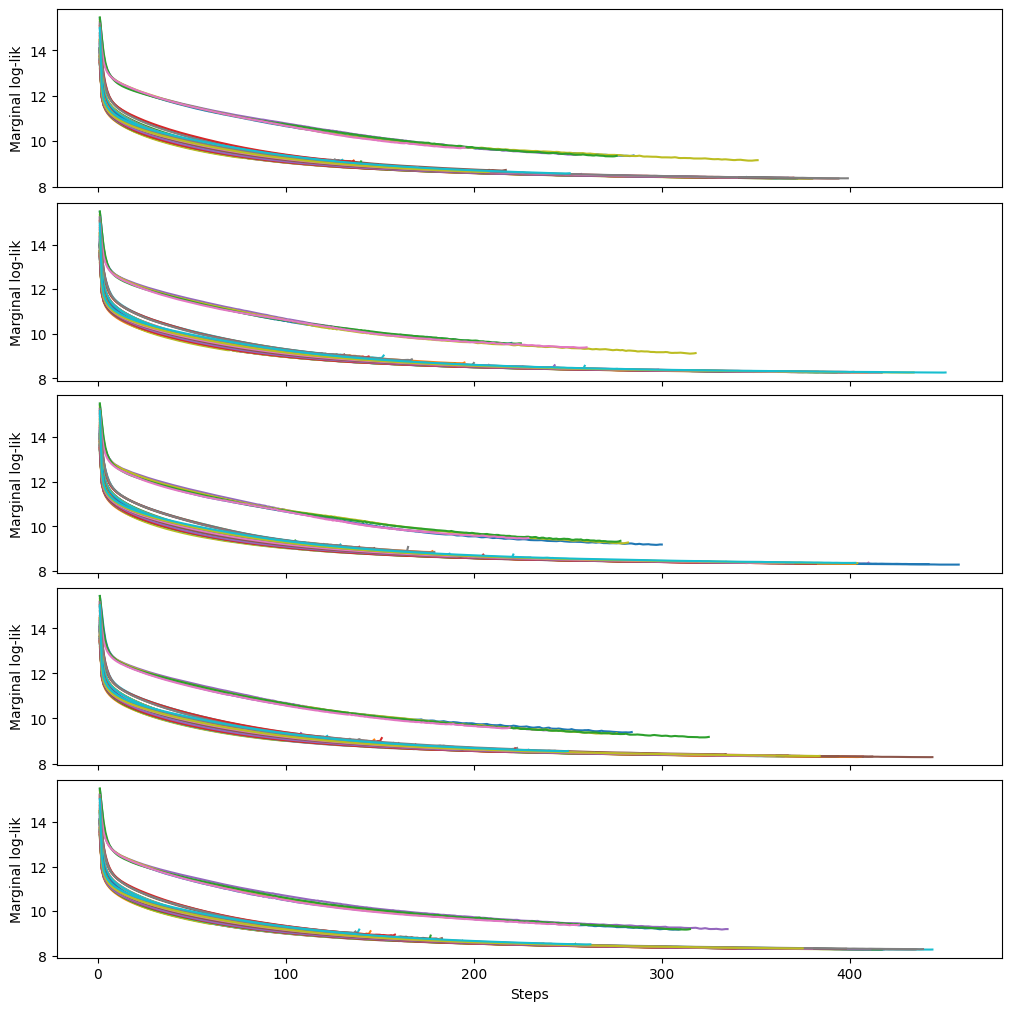

In [32]:
f,axs = plt.subplots(n_folds,1,constrained_layout=True,figsize=(10,2*n_folds), sharex=True)
for fold_i,ax in zip(range(n_folds), axs):
    for gp_i in gp_index[gp_index.get_locs(pd.IndexSlice[fold_i,:,:])]:
        ax.plot([r.step for r in optimization_trace[gp_i]], [r.fval for r in optimization_trace[gp_i]])
    ax.set_ylabel('Marginal log-lik');
axs.flat[-1].set_xlabel('Steps');
plt.show(f);plt.close(f)
# print(optimization_trace[-1].status, optimization_trace[-1].message)

## Metrics

In [33]:
metrics = pd.DataFrame(columns=['acc','auc'],index=gp_index)

In [34]:
n_plots = n_folds
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))
# f,axs = plt.subplots(n_rows,n_cols, sharey=True, sharex=True, figsize=(n_cols*4, n_rows*4))
for fold_i in fold_index:
    train_idx, test_idx = idx_splits[fold_i]
    test_classes = all_classes[test_idx]
    test_embeddings = all_embeddings[test_idx]
    for gp_i in gp_index[gp_index.get_locs(pd.IndexSlice[fold_i,:,:])]:
        model = models[gp_i]
        model.eval()
        with torch.no_grad():
            test_pred_dist = model(test_embeddings)

        test_pred_samples = test_pred_dist.sample(torch.Size((256,))).exp()
        test_probabilities = (test_pred_samples / test_pred_samples.sum(1, keepdim=True)).mean(0).detach().cpu()
        test_pred_class = torch.argmax(test_probabilities,dim=0,keepdim=False)

        acc = sklearn.metrics.accuracy_score(test_classes, test_pred_class)
        auc = sklearn.metrics.roc_auc_score(test_classes,test_probabilities.T,multi_class="ovo")
        metrics.at[gp_i, 'acc'] = acc
        metrics.at[gp_i, 'auc'] = auc

        # disp = sklearn.metrics.ConfusionMatrixDisplay(
        #     sklearn.metrics.confusion_matrix(test_classes, test_pred_class),
        #     display_labels=class_labels
        # )
        # axs.flat[fold_i].set_title(f'Fold {fold_i+1:02d} (ACC: {acc*100:0.2f} AUC: {auc:0.2f})')
        # disp.plot(ax=axs.flat[fold_i], colorbar=False);

E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
E:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\linear_operator\utils\cholesky.py:40: Numeric

In [35]:
print('Metrics')
display(metrics.apply(lambda y: f'{y.mean():0.2f} ± {2*y.std():0.2f}').to_frame().T)
print('Metrics by latent dimension')
display(metrics.groupby(level=[2]).apply(lambda x: x.apply(lambda y: f'{y.mean():0.2f} ± {2*y.std():0.2f}')))

Metrics


,acc,auc
0,0.71 ± 0.06,0.86 ± 0.07


Metrics by latent dimension


,acc,auc
dim_i,,
2,0.65 ± 0.04,0.76 ± 0.03
5,0.72 ± 0.04,0.85 ± 0.03
10,0.73 ± 0.04,0.88 ± 0.03
12,0.73 ± 0.05,0.88 ± 0.03
15,0.73 ± 0.05,0.88 ± 0.03
20,0.73 ± 0.05,0.88 ± 0.03
30,0.71 ± 0.04,0.87 ± 0.03
40,0.71 ± 0.05,0.86 ± 0.03
50,0.71 ± 0.05,0.86 ± 0.03
